In [25]:
import numpy as np
import pandas as pd

In [26]:
# Columns we want from the dataset
columns_to_use = ['game_date', 'yardline_100', 'yrdln', 'ydstogo', 'ydsnet', 'desc', 'play_type', 'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'field_goal_result', 'kick_distance', 'extra_point_result', 'two_point_conv_result', 'incomplete_pass', 'interception', 'qb_hit', 'pass_attempt', 'rush_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'passer_player_id', 'passer_player_name', 'receiver_player_id', 'receiver_player_name', 'rusher_player_id', 'rusher_player_name']

### Fetched the following dataset from Kaggle:

https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016?select=NFL+Play+by+Play+2009-2018+%28v5%29.csv

In [252]:
df = pd.read_csv("nfl_play_by_play.csv", usecols=columns_to_use)

/home/ec2-user/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [253]:
# Only want rows that correspond to the 4 specific play types
# And let's make sure we drop the old index
df = df[df['play_type'].isin(['pass', 'run', 'field_goal', 'extra_point'])].reset_index(drop=True)

In [254]:
def convertGameDateToSeason(game_date):
    # If the month is January or February, that means we are in the prior season. So year - 1
    # (game_date.month <= 2) will be 1 if prior season. 0 otherwise.
    return game_date.year - (game_date.month <= 2)

In [255]:
# Let's check the type of game date as we want to ensure it is a datetime object
df.dtypes['game_date']

dtype('O')

In [256]:
# Convert to a datetime object since it wasn't already
df['game_date'] = pd.to_datetime(df['game_date'])

In [257]:
# Let's double check
df.dtypes['game_date']

dtype('<M8[ns]')

In [258]:
# Create a new field to represent the season
df['season'] = df['game_date'].map(convertGameDateToSeason)

In [259]:
# Let's save all the plays by season for easy consumption later
for year in df['season'].unique():
    df[df['season'] == year].to_csv(f"season_datasets/{year}_plays.csv", index=False)

__Now that we have populated the files, let's read them and derive some extra columns we may want for our visualizations__


In [260]:
import numpy as np
import pandas as pd
import re

In [261]:
df['pass_location'].unique()

array(['left', nan, 'right', 'middle'], dtype=object)

__The pass location field doesn't provide the added level of granularity I want for my analysis so let's try parsing the description__

In [262]:
# Let's take a look at the pass plays that have no location
for description in df[(df['play_type'] == 'pass') & (df['pass_location'].isna())].sample(10).desc:
    print(description)

(6:02) (Shotgun) B.Weeden sacked at BAL 50 for -9 yards (E.Dumervil).
(4:01) T.Taylor sacked at BUF 13 for -7 yards (D.Harris).
(5:42) (Shotgun) A.Smith sacked at KC 30 for -4 yards (F.Cox).
(9:28) T.Yates sacked at HOU 29 for -3 yards (M.Lawson).
(2:09) D.Brees sacked at NO 15 for -5 yards (J.Watt).
(9:13) (Shotgun) A.Smith sacked at TEN 38 for -4 yards (B.Orakpo).
(11:10) (Shotgun) R.Tannehill sacked at PHI 24 for -9 yards (sack split by F.Cox and V.Curry).
(12:43) R.Fitzpatrick sacked at BUF 42 for -10 yards (S.Ellis). NYJ-S.Ellis was injured during the play. His return is Questionable.
(5:21) (Shotgun) T.Romo sacked at DAL 35 for -6 yards (A.Carter).
(10:29) (Shotgun) C.Wentz pass to C.Wentz to CIN 28 for 7 yards (V.Burfict). {Pass tipped by #93 W.Clarke}


__There are some that are passes with no location. But most of these look like sacks. So we can remove them from our analysis for now__

In [263]:
# Let's just check the number of each of the pass locations so we feel more comfortable filtering out.
print("Number of pass plays for each pass location")
print("="*50)
print("No Location: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'].isna())]))
for location in ['left', 'right', 'middle']:
    print(f"{location}: ", len(df[(df['play_type'] == 'pass') & (df['pass_location'] == location)]))

Number of pass plays for each pass location
No Location:  12818
left:  62909
right:  70110
middle:  40840


In [264]:
# Let's see some sample description for each of the passing locations
for location in ['left', 'right', 'middle']:
    print("="*40, location, "="*40)
    for description in df[(df['play_type'] == 'pass') & (df['pass_location'] == location)].sample(5).desc:
        print(description)

======================================== left ========================================
(10:29) T.Brady pass short left to W.Welker ran ob at 50 for 14 yards. NE 12-Brady 51st career 300-yard game, tying Dan Fouts for 6th most all-time.
(6:50) E.Manning pass short left to T.Beckum for 1 yard, TOUCHDOWN.
(4:36) (Shotgun) A.Rodgers pass short left to D.Driver to GB 27 for 5 yards (J.Wilhite).
(7:24) D.Brees pass short left to M.Ingram to NO 31 for 16 yards (C.Jones; E.Goldman). Pass -5, YAC 21
(13:53) A.Dalton pass short left to M.Jones to CIN 35 for 3 yards (R.Marshall).
======================================== right ========================================
(15:00) M.Schaub pass incomplete short right to C.Brown.
(:22) N.Foles pass deep right to J.Cook ran ob at SEA 16 for 20 yards.
(11:53) (Shotgun) B.Roethlisberger pass incomplete short right to H.Miller (D.Jackson).
(7:00) (Run formation) R.Tannehill pass short right to B.Hartline to IND 21 for 7 yards (J.Powers).
(10:55) (Shotgun) J.

In [265]:
# Let's see if we can properly parse enough of the rows to get enough data for our analysis
df['pass_loc_detailed'] = df[df['play_type'] == 'pass']['desc'].str.extract(r"pass (?:incomplete )?([A-Za-z\s]+?)\.? (?:to|intended|intercepted)", flags=re.IGNORECASE)

In [266]:
# Let's see what we got!
df['pass_loc_detailed'].value_counts()

short right              56622
short left               50554
short middle             32976
deep right               12439
deep left                11969
deep middle               7699
incomplete                 103
right                       17
left                        16
middle                      12
short left end               3
short right end              2
was                          2
was thrown incomplete        1
Name: pass_loc_detailed, dtype: int64

__Since we want the extra granularity, let's just keep the first 6 listed above.__  
__Should be okay since the ones we are filtering out make up an extremely tiny porition of the data.__


In [267]:
# Let's just ensure that we can get the top 6 locations without having to hardcode based on the data
# We could also consider doing this by a percentage threshold but this is probably fine for now.
valid_locations = df['pass_loc_detailed'].value_counts().index[0:6]

In [268]:
valid_locations

Index(['short right', 'short left', 'short middle', 'deep right', 'deep left',
       'deep middle'],
      dtype='object')

In [269]:
df.loc[(df['play_type'] == 'pass') & ~(df['pass_loc_detailed'].isin(valid_locations)), 'pass_loc_detailed'] = np.nan

In [270]:
# Let's see what we got after we filtered out a bit
df['pass_loc_detailed'].value_counts()

short right     56622
short left      50554
short middle    32976
deep right      12439
deep left       11969
deep middle      7699
Name: pass_loc_detailed, dtype: int64

__For fun, let's inspect the field goal and extra point success over the years.__

In [271]:
# Let's first see the possible values for the extra point.
df.loc[df['play_type'] == 'extra_point', 'extra_point_result'].unique()

array(['good', 'failed', 'blocked', 'aborted'], dtype=object)

__We only want to consider plays where the kicker actually kicked the ball. So we can filter out "aborted"__

In [272]:
# Let's swap aborted to NaN
df['extra_point_result'] = df['extra_point_result'].replace(to_replace="aborted", value=np.nan)

In [273]:
# Let's double check that we only have 3 non-NaN results
df.loc[df['play_type'] == 'extra_point', 'extra_point_result'].unique()

array(['good', 'failed', 'blocked', nan], dtype=object)

In [274]:
# Let's just rename to Made or Missed for ease
df['extra_point_result'] = df['extra_point_result'].replace(to_replace=["good", "failed", "blocked"], value=["Made", "Missed", "Missed"])

In [275]:
import matplotlib.pyplot as plt
import seaborn as sns

In [276]:
xp_kicks_by_season.index.to_flat_index()

Int64Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64', name='season')

In [277]:
xp_kicks_by_season = df[df['extra_point_result'] == 'Made'].groupby(['season']).agg({'extra_point_result': 'count'}).div(df[~df['extra_point_result'].isna()].groupby(['season']).agg({'extra_point_result': 'count'})).rename(columns={"extra_point_result": "XP Pct"})

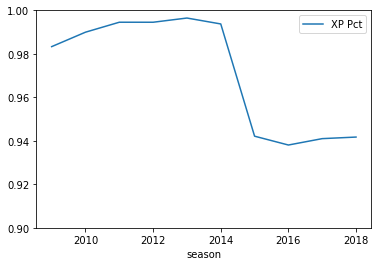

In [278]:
ax = sns.lineplot(data=xp_kicks_by_season);
ax.set(ylim=(.9, 1));

In [279]:
# Let's first see the possible values for the field goal
df.loc[df['play_type'] == 'field_goal', 'field_goal_result'].unique()

array(['missed', 'blocked', 'made'], dtype=object)

In [280]:
# Let's just classify a block as a miss
df['field_goal_result'] = df['field_goal_result'].replace(to_replace="blocked", value="missed")

In [281]:
# Let's verify it changed
df.loc[df['play_type'] == 'field_goal', 'field_goal_result'].unique()

array(['missed', 'made'], dtype=object)

In [282]:
# Now, let's check if we have any NaN for kick distance
len(df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())])

8

In [294]:
# Since a small number, let's just use the yard line and add 18 to get the kick distance.
df.loc[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna()), 'kick_distance'] = df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())]['yardline_100'] + 18

In [295]:
# Let's double check it worked
len(df[(df['play_type'] == 'field_goal') & (df['kick_distance'].isna())])

0

In [310]:
def convertKickDistanceToFgRange(distance):
    rangeBegin = int(10*(distance//10))
    return f"{rangeBegin}-{rangeBegin+9}"

In [324]:
df['fg_range'] = df[df['play_type'] == 'field_goal']['kick_distance'].map(convertKickDistanceToFgRange, na_action='ignore')

In [325]:
# Let's check if it spit out what we expected
df['fg_range'].unique()

array([nan, '30-39', '40-49', '20-29', '50-59', '60-69', '10-19', '70-79'],
      dtype=object)

In [329]:
fg_kicks_by_season = df[~df['fg_range'].isna()].groupby(['season', 'fg_range']).size().to_frame("num_kicks")

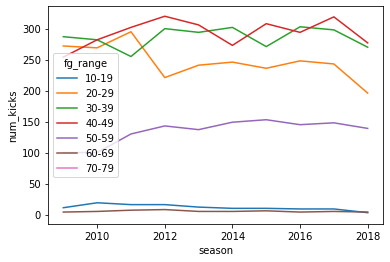

In [330]:
sns.lineplot(data=fg_kicks_by_season.reset_index(), x='season', y='num_kicks', hue='fg_range');

In [314]:
pct_fg_by_season = df[df['field_goal_result'] == 'made'].groupby(['season', 'fg_range']).agg({'field_goal_result': 'count'}).div(df[~df['field_goal_result'].isna()].groupby(['season', 'fg_range']).agg({'field_goal_result': 'count'})).rename(columns={"field_goal_result": "FG Pct"})

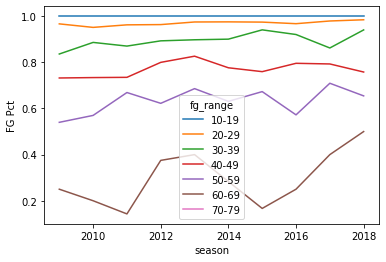

In [316]:
sns.lineplot(data=fg_kicks_by_season.reset_index(), x='season', y='FG Pct', hue='fg_range');

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
pass_locations_by_season = df[~df['pass_loc_detailed'].isna()].groupby(['season', 'pass_loc_detailed']).size().to_frame("num_plays")

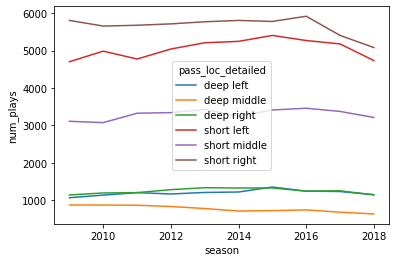

In [156]:
sns.lineplot(data=pass_locations_by_season.reset_index(), x='season', y='num_plays', hue='pass_loc_detailed');